## DarkELF absorption notebook

This notebook is meant to illustrate how to use DarkELF to calculate dark photon absorption rates.

written by Tongyan Lin & Simon Knapen, 04/20/2021

In [21]:
%matplotlib inline

import sys, os
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker
from matplotlib import rc, rcParams
import matplotlib.cm as cm
from mpl_toolkits.axes_grid1 import make_axes_locatable

# Make use of TeX\ufeff
rc('text',usetex=True)
# Change all fonts to 'Computer Modern'
rc('font',**{'size':14, 'family':'serif','serif':['Times New Roman']})
rc('xtick.major', size=5, pad=7)
rc('xtick', labelsize=15)
rc('ytick.major', size=5, pad=7)
rc('ytick', labelsize=15)

# uses matplotlib-label-lines, see for example https://github.com/cphyc/matplotlib-label-lines
from labellines import labelLine, labelLines

# this needs to point to the folder where darkelf.py is stored
work_dir = os.getcwd()
sys.path.append(work_dir+"/..")
plotdir=work_dir+"/plots/"

from darkelf import darkelf, targets

Most materials come with grids for both phonon ELFs and electronic ELFs:

In [22]:
targets.files("Si")

Available configuration files: 
	 Si.yaml
 
Available data for epsilon: 
	 Si_Migdal_FAC.dat
	 Si_mermin.dat
	 Si_gpaw_noLFE.dat
	 Si_gpaw_withLFE.dat
	 Si_epsphonon_theory6K.dat
	 Si_epsphonon_data6K.dat


## Example

To make use of phonon processes, a phonon ELF file has to be specified using the "phonon_filename" flag:

In [23]:
si = darkelf(mX=1e1,target='Si',filename='Si_gpaw_noLFE.dat',phonon_filename="Si_epsphonon_data6K.dat")

 .... Loading files for Si
Loaded Si_gpaw_noLFE.dat for epsilon in electron regime
Loaded Si_epsphonon_data6K.dat for epsilon in phonon regime


In [24]:
?si.R_absorption

Signature: si.R_absorption(kappa=1e-15)
Docstring:
Returns rate for dark photon absorption, events per 1/kg/yr. Will use electronic ELF for mX > electronic band gap and phonon ELF otherwise. If the required ELF is not loaded or if mX is outside the range of the grid, the function will return zero.
Inputs
------
kappa: float
    kinetic mixing parameter for dark photon model
Outputs
-------
absorption rate [1/kg/yr]
File:      ~/Documents/work/projects/DM_stuff/darkELF_public/darkelf/absorption.py
Type:      method


In [25]:
print(si.R_absorption(kappa=1.0))

8.067874215350226e+32


Simple function to extract a limit, assuming 3.6 events

In [26]:
def kappa_limit(target,mX):
    scalar_input = np.isscalar(mX)
    mXlist = np.atleast_1d(mX)
    lim=[]
    
    for mX in mXlist:
        target.update_params(mX=mX)
        rate=target.R_absorption(kappa=1.0)
        if rate==0.0:
            lim.append(np.nan)
        else:
            lim.append(np.sqrt(3.0/rate))
            
    if(scalar_input):
        return lim[0]
    else:
        return np.array(lim) 

In [27]:
# electron regime
print(kappa_limit(si,10.0))

# phonon regime
print(kappa_limit(si,0.1))

6.679926610396326e-17
9.284338949869414e-15


# Plot with many targets

In [28]:
ge = darkelf(target='Ge',filename='Ge_gpaw_noLFE.dat',phonon_filename="Ge_epsphonon_data2K.dat")
simermin = darkelf(target='Si',filename='Si_mermin.dat',phonon_filename="Si_epsphonon_data6K.dat")
gemermin = darkelf(target='Ge',filename='Ge_mermin.dat',phonon_filename="Ge_epsphonon_data2K.dat")

GaAs = darkelf(target='GaAs',filename="GaAs_mermin.dat",phonon_filename="GaAs_epsphonon_data10K.dat")

GaN = darkelf(target='GaN',filename="GaN_mermin.dat",phonon_filename="GaN_epsphonon_300K.dat")

Al = darkelf(target='Al',filename="Al_mermin.dat")

SiO2 = darkelf(target='SiO2',filename="SiO2_mermin.dat",phonon_filename="SiO2_epsphonon_o.dat")
SiO2_e = darkelf(target='SiO2',targetyaml='SiO2_extraordinary',
                 filename="SiO2_mermin.dat",phonon_filename="SiO2_epsphonon_e.dat")

SiC = darkelf(target='SiC',phonon_filename="SiC_epsphonon_3C.dat")
ZnS = darkelf(target='ZnS',filename="ZnS_mermin.dat",phonon_filename="ZnS_epsphonon_300K.dat")

Al2O3 = darkelf(target='Al2O3',filename="Al2O3_mermin.dat",phonon_filename="Al2O3_epsphonon_o.dat")
Al2O3_e = darkelf(target='Al2O3',targetyaml='Al2O3_extraordinary',filename="Al2O3_mermin.dat",phonon_filename="Al2O3_epsphonon_e.dat")


 .... Loading files for Ge
Loaded Ge_gpaw_noLFE.dat for epsilon in electron regime
Loaded Ge_epsphonon_data2K.dat for epsilon in phonon regime
 .... Loading files for Si
Loaded Si_mermin.dat for epsilon in electron regime
Loaded Si_epsphonon_data6K.dat for epsilon in phonon regime
 .... Loading files for Ge
Loaded Ge_mermin.dat for epsilon in electron regime
Loaded Ge_epsphonon_data2K.dat for epsilon in phonon regime
 .... Loading files for GaAs
Loaded GaAs_mermin.dat for epsilon in electron regime
Loaded GaAs_epsphonon_data10K.dat for epsilon in phonon regime
Warning! Atomic Migdal calculation not present
 .... Loading files for GaN
Loaded GaN_mermin.dat for epsilon in electron regime
Loaded GaN_epsphonon_300K.dat for epsilon in phonon regime
Warning! Atomic Migdal calculation not present
 .... Loading files for Al
Loaded Al_mermin.dat for epsilon in electron regime
Warning! eps for phonon frequencies not loaded. Need to set phonon_filename 
Warning! Atomic Migdal calculation not pres

For Ge, there are some unphysical wiggles at high omega. This due to a numerical artifact when converting the Novak et al parametrization to the Mermin model. We smooth this out by fitting the rate to a smooth polynomial:

/opt/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3331: RankWarning: Polyfit may be poorly conditioned
  exec(code_obj, self.user_global_ns, self.user_ns)


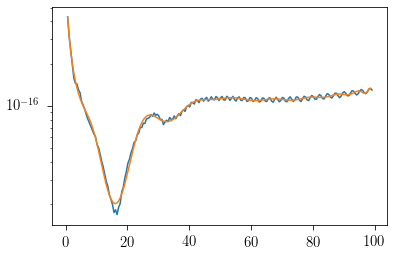

In [29]:
mVelectron = np.linspace(gemermin.E_gap,100,200)
mVphonon = np.linspace(.03,.08,100)
a = kappa_limit(gemermin,mVelectron)

fitparam=np.polyfit(mVelectron[:-3],np.log10(a)[:-3],30)
aa = (lambda mV: 10**np.poly1d(fitparam)(mV))

plt.plot(mVelectron,a,label='Ge')
plt.plot(mVelectron[:-3],list(map(aa,mVelectron[:-3])),label='Ge')
plt.yscale("log")
plt.show()


/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: RuntimeWarning: invalid value encountered in sqrt
  if sys.path[0] == '':
/opt/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3331: RankWarning: Polyfit may be poorly conditioned
  exec(code_obj, self.user_global_ns, self.user_ns)


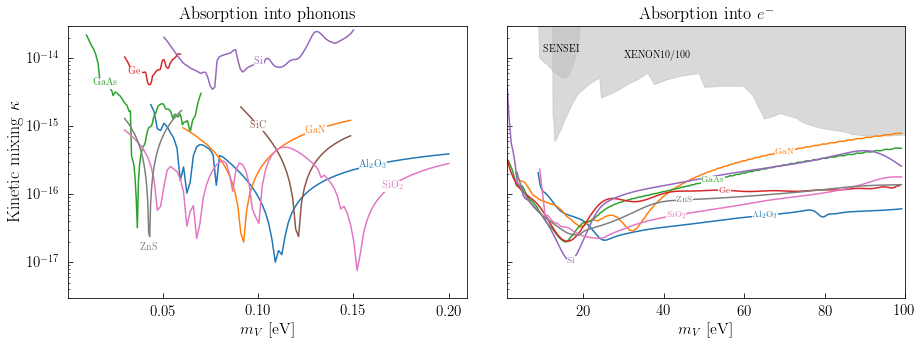

In [30]:
cmap = plt.get_cmap('tab10')
colors = cmap(np.linspace(0.0,1.0,10))

fig, axs = plt.subplots(1,2,figsize=(15,5),sharey=True)
fig.subplots_adjust(wspace=0.1)

props = dict(facecolor='white', alpha=0.9, edgecolor='white',boxstyle="square,pad=0.025")

# Al2O3
mVelectron = np.linspace(Al2O3.E_gap,100,200)
mVphonon = np.linspace(.03,.2,100)
a = kappa_limit(Al2O3,mVelectron)
axs[1].plot(mVelectron,a,color=colors[0],label=r'Al$_2$O$_3$')
b1 = kappa_limit(Al2O3,mVphonon)
b2 = kappa_limit(Al2O3_e,mVphonon)
b = pow(1./3*1./b1**2 + 2./3*1./b2**2,-0.5)
axs[0].plot(mVphonon,b,color=colors[0],label=r'Al$_2$O$_3$')

# GaN
mVelectron = np.linspace(GaN.E_gap,100,200)
mVphonon = np.linspace(.05,.2,100)
a = kappa_limit(GaN,mVelectron)
axs[1].plot(mVelectron,a,color=colors[1],label='GaN')
b = kappa_limit(GaN,mVphonon)
axs[0].plot(mVphonon,b,color=colors[1],label='GaN')

# GaAs
mVelectron = np.linspace(GaAs.E_gap,100,200)
mVphonon = np.linspace(.01,.07,100)
a = kappa_limit(GaAs,mVelectron)
axs[1].plot(mVelectron,a,color=colors[2],label='GaAs')
b = kappa_limit(GaAs,mVphonon)
axs[0].plot(mVphonon,b,color=colors[2],label='GaAs')


# Ge
mVelectron = np.linspace(gemermin.E_gap,100,200)
mVphonon = np.linspace(.03,.08,100)
a = kappa_limit(gemermin,mVelectron)
fitparam=np.polyfit(mVelectron[:-3],np.log10(a)[:-3],30) # need to smooth out Ge curve, due to numerical artifact
aa = (lambda mV: 10**np.poly1d(fitparam)(mV))
axs[1].plot(mVelectron[:-3],list(map(aa,mVelectron[:-3])),color=colors[3],label='Ge')
b = kappa_limit(gemermin,mVphonon)
axs[0].plot(mVphonon,b,color=colors[3],label='Ge')

# SI
mVelectron = np.linspace(simermin.E_gap,100,200)
mVphonon = np.linspace(.03,.15,100)
a = kappa_limit(simermin,mVelectron)
axs[1].plot(mVelectron,a,color=colors[4],label='Si')
b = kappa_limit(simermin,mVphonon)
axs[0].plot(mVphonon,b,color=colors[4],label='Si')

# SIC
mVphonon = np.linspace(.05,.2,100)
b = kappa_limit(SiC,mVphonon)
axs[0].plot(mVphonon,b,color=colors[5],label='SiC')

# SIO2
mVelectron = np.linspace(SiO2.E_gap,100,200)
mVphonon = np.linspace(.03,.2,100)
a = kappa_limit(SiO2,mVelectron)
axs[1].plot(mVelectron,a,color=colors[6],label=r'SiO$_2$')
b1 = kappa_limit(SiO2,mVphonon)
b2 = kappa_limit(SiO2_e,mVphonon)
b = pow(1./3*1./b1**2 + 2./3*1./b2**2,-0.5)
axs[0].plot(mVphonon,b,color=colors[6],label=r'SiO$_2$')

# ZnS
mVelectron = np.linspace(ZnS.E_gap,100,200)
mVphonon = np.linspace(.03,.08,100)
a = kappa_limit(ZnS,mVelectron)
axs[1].plot(mVelectron,a,color=colors[7],label='ZnS')
b = kappa_limit(ZnS,mVphonon)
axs[0].plot(mVphonon,b,color=colors[7],label='ZnS')

### Plot settings for left panel
axs[0].set_yscale('log')
axs[0].set_ylim([3e-18,3e-14])
axs[0].tick_params(direction='in',which='both',pad=8)
axs[0].set_xlabel(r'$m_V$ [eV]',fontsize=16)
axs[0].set_ylabel(r'Kinetic mixing $\kappa$',fontsize=18)

lines = axs[0].get_lines()
labelLines(lines,xvals=[0.16,0.13,.02,0.035,0.1,0.1,0.17],fontsize=10,zorder=2.5,
           ha='center',va='center',align=False,bbox=props)
axs[0].text(0.038,1.5e-17,r'ZnS',color=colors[7],fontsize=10,bbox=props)
axs[0].set_title('Absorption into phonons')

### Plot settings for right panel

dat = np.loadtxt('data/kappa_limit_xenon.txt').T
axs[1].fill_between(dat[0],dat[1],dat[1]*0.0+1e-13,color='Silver',alpha=0.6)
dat = np.loadtxt('data/kappa_limit_SENSEI2020.txt').T
axs[1].fill_between(dat[0],dat[1],dat[1]*0.0+1e-13,color='Silver',alpha=0.6)
axs[1].text(30,1e-14,'XENON10/100',fontsize=10)
axs[1].text(10,1.2e-14,'SENSEI',fontsize=10)

axs[1].set_xlim([1.0,100])
axs[1].tick_params(direction='in',which='both',pad=8)
axs[1].set_xlabel(r'$m_V$ [eV]',fontsize=16)

lines = axs[1].get_lines()
labelLines(lines,xvals=[65,70,52,55,17,43,45],fontsize=9,zorder=2.5,
           ha='center',va='center',align=False,bbox=props)
axs[1].set_title('Absorption into $e^-$')

fig.savefig('plots/darkelf_absorption_1.pdf',bbox_inches='tight')

### The reach does not depend too much on how ordinary and extraordinary response are averaged

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: RuntimeWarning: invalid value encountered in sqrt
  if sys.path[0] == '':


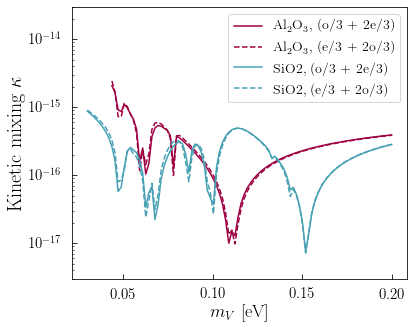

In [32]:
cmap = plt.get_cmap('Spectral')
colors = cmap(np.linspace(0.0,1.0,8))

fig, axs = plt.subplots(1,1,figsize=(6,5))

# Al2O3
mVphonon = np.linspace(.03,.2,100)
b1 = kappa_limit(Al2O3,mVphonon)
b2 = kappa_limit(Al2O3_e,mVphonon)
# 1/3 * ordinary + 2/3 * extraordinary
b = pow(1./3*1./b1**2 + 2./3*1./b2**2,-0.5)
axs.plot(mVphonon,b,color=colors[0],label=r'Al$_2$O$_3$, (o/3 + 2e/3)')
# 2/3 * ordinary + 1/3 * extraordinary
b = pow(2./3*1./b1**2 + 1./3*1./b2**2,-0.5)
axs.plot(mVphonon,b,color=colors[0],label=r'Al$_2$O$_3$, (e/3 + 2o/3)',linestyle='--')

# SIO2
mVphonon = np.linspace(.03,.2,100)
b1 = kappa_limit(SiO2,mVphonon)
b2 = kappa_limit(SiO2_e,mVphonon)
# 1/3 * ordinary + 2/3 * extraordinary
b = pow(1./3*1./b1**2 + 2./3*1./b2**2,-0.5)
axs.plot(mVphonon,b,color=colors[6],label='SiO2, (o/3 + 2e/3)')
# 2/3 * ordinary + 1/3 * extraordinary
b = pow(2./3*1./b1**2 + 1./3*1./b2**2,-0.5)
axs.plot(mVphonon,b,color=colors[6],label='SiO2, (e/3 + 2o/3)',linestyle='--')

### Plot settings for left panel
axs.set_yscale('log')
axs.set_ylim([3e-18,3e-14])
axs.tick_params(direction='in',which='both',pad=10)
axs.set_xlabel(r'$m_V$ [eV]',fontsize=18)
axs.set_ylabel(r'Kinetic mixing $\kappa$',fontsize=20)

axs.legend()
fig.savefig('plots/darkelf_absorption_2.pdf',bbox_inches='tight')